# DESI MWS DESIGN EXAMPLE

* Defines a subset of tiles to be observed with the default MWS target selection, but going through the gynmastics we need to test alternative SV selections.
* Defines target classes with a custom YAML file (in this example case, this is just a duplicate of the main survey definition).
* Patches `desistarget.cuts` with custom functions implementing MWS SV selection cuts.
* Selects targets from sweeps using `desitarget.cuts.select_targets`.
* In this example we ignore BGS. We still get some objects selected as BGS_ANYH, because these also meet the MWS cuts.

In [1]:
RUN_NAME = 'tutorial_main_survey'

In [6]:
# %load scripts/nbpreamble.py
if not 'RUN_NAME' in locals():
    RUN_NAME = 'unknown'

import sys
import os
import shutil
import glob
import numpy as np
import warnings
import subprocess
import matplotlib
import matplotlib.pyplot as pl
from   matplotlib.patches import Circle, Polygon, RegularPolygon
%matplotlib inline

from desitarget.cuts import select_targets, qso_selection_options

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", module='desitarget')
    # Tries to set mpl backend
    from desitarget.QA import _parse_tcnames

from desiutil.log import get_logger

from importlib import reload

add_sys_path = list()
add_sys_path.append(os.path.join(os.getcwd(),'py'))

WITH_SPHERICAL_GEOMETRY = True
if WITH_SPHERICAL_GEOMETRY:
    add_sys_path.append(os.path.join(os.environ['HOME'],
                                 'software/modules/spherical_geometry/master/lib/python3.6/site-packages/spherical_geometry-1.2.5-py3.6-linux-x86_64.egg/'))

for _ in add_sys_path:
    if _ not in sys.path:
        sys.path.append(_)
                    
from apcsv.astropy_backports import *

if WITH_SPHERICAL_GEOMETRY:
    import spherical_geometry
    from spherical_geometry import polygon as spoly

import astropy
import astropy.units as u
import astropy.coordinates as coord
import regions
from   astropy.io import fits
from   astropy.table import Table, Column

import desiutil
import desiutil.plots
import desimodel
import desimodel.focalplane
import desitarget

with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=UserWarning, module="matplotlib")
    # Tries to set mpl backend
    import desitarget
import desitarget.io as io
import desitarget.mtl

import desitarget.targetmask
from   desitarget.targetmask import desi_mask, bgs_mask, mws_mask, obsmask, obsconditions

import fitsio

# SV planning object classes
import apcsv.plan
reload(apcsv.plan)
from apcsv.plan import Tile, Dither

# Helpful function to deal with multiple warnings
def warning_summary(W):
    if len(W) == 0:
        print('No warnings')
        return
    
    import collections
    d = collections.defaultdict(lambda: 0)
    for _ in W: d[_.category.__name__] += 1
        
    print('{:15s} {:s}'.format('WARNING','COUNT'))
    for k,v in d.items():
        print('{:15s} {:d}'.format(k,v))

# Print some debug info
!date
for m in [astropy,np]:
    print('{:15s} {:20s}'.format(m.__name__,m.version.version))
for m in [desitarget,desimodel]:
    print('{:15s} {:20s}'.format(m.__name__,m._version.__version__))
!echo 'fiberassign    ' $(fiberassign_exec --version)   

print()
print('Path to fiberassign_exec:')
!which fiberassign_exec

print()
print('Working dir:', os.getcwd())

# Write all the files under this path
ROOT_DIR  = os.getcwd()
WORK_ROOT = os.path.join(ROOT_DIR,'runs',RUN_NAME)
print('Files will be written under {}'.format(WORK_ROOT))

if not os.path.exists(WORK_ROOT):
    os.makedirs(WORK_ROOT)
    
print()
print('Files under this directory:')
!tree --noreport -C --filelimit 10 -I '*.py*' $ROOT_DIR

print()
print('Files under the run directory:')
!date
!tree --noreport -C -D --filelimit 10 $WORK_ROOT/run

print()
print('Useful numbers:')
R_TILE = desimodel.focalplane.get_tile_radius_deg()
A_TILE = np.pi*R_TILE**2
print('Tile radius: {:4.3f} deg'.format(R_TILE))
print('Tile area:   {:4.3f} sq.deg.'.format(A_TILE))

# Set up paths
rundir   = os.path.join(WORK_ROOT,'run')
datadir  = os.path.join(rundir,'data')
outdir   = os.path.join(rundir,'output')

for _dir in [rundir,datadir,outdir]:
    os.makedirs(_dir,exist_ok=True)  
    
resource_paths = {
     "skies"  : "/project/projectdirs/desi/target/catalogs/dr7.1/0.22.0/", 
     "gfas"   : "/project/projectdirs/desi/target/catalogs/dr7.1/0.22.0/",
}

resource_names = {
    "skies"   : "dr7.1-0.22.0.fits", 
    "gfas"    : "dr7.1.fits",
}

mtl_path           = os.path.join(datadir, 'mtl.fits')
std_path           = os.path.join(datadir, 'std.fits')
local_targets_path = os.path.join(datadir, 'sv_targets.fits')

sky_path     = os.path.join(resource_paths["skies"], 
                          "skies-{}".format(resource_names["skies"]))
gfa_path     = os.path.join(resource_paths["gfas"], 
                          "gfas-{}".format(resource_names["gfas"]))



Thu Mar 14 20:57:16 PDT 2019
astropy         2.0.7               
numpy           1.13.3              
desitarget      0.28.0.dev2909      
desimodel       0.9.10.dev477       
fiberassign     0.11.1.dev2271

Path to fiberassign_exec:
/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/code/fiberassign/master/bin/fiberassign_exec

Working dir: /global/u1/a/apcooper/projects/mws_svplan
Files will be written under /global/u1/a/apcooper/projects/mws_svplan/runs/tutorial_main_survey

Files under this directory:
/global/u1/a/apcooper/projects/mws_svplan [23 entries exceeds filelimit, not opening dir]

Files under the run directory:
Thu Mar 14 20:57:16 PDT 2019
/global/u1/a/apcooper/projects/mws_svplan/runs/tutorial_main_survey/run
├── [Mar 14  2:51]  data
│   ├── [Mar 14  2:51]  mtl.fits
│   ├── [Mar 14  2:51]  std.fits
│   └── [Mar 14  2:50]  sv_targets.fits
└── [Mar 14  2:55]  output
    ├── [Mar 14  2:53]  fiberassign_000000.fits
    └── [Mar 14  2:55]  tile-000000.fits

Usef

In [7]:
# Read the sweeps to use for targeting directly 
SWEEPS_RESET = False

SWEEPS_DIR = '/project/projectdirs/cosmo/data/legacysurvey/dr7/sweep'
SWEEPS_VER = '7.1'
SWEEPS_HEADER_CACHE = os.path.join(ROOT_DIR,'cache/sweeps/')

if not os.path.exists(os.path.join(SWEEPS_HEADER_CACHE,SWEEPS_VER)):
    os.makedirs(os.path.join(SWEEPS_HEADER_CACHE,SWEEPS_VER))

original_sweep_files = io.list_sweepfiles(os.path.join(SWEEPS_DIR,SWEEPS_VER))

sweep_headers = list()
for _ in original_sweep_files:
    _base  = os.path.basename(_)
    _cache = os.path.join(SWEEPS_HEADER_CACHE,SWEEPS_VER,_base)
    if not os.path.exists(_cache) or SWEEPS_RESET:
        h = fits.getheader(_)
        h.tofile(_cache,overwrite=True)
    else:
        h = astropy.io.fits.header.Header.fromfile(_cache)
    sweep_headers.append(h)

nsweeps = len(sweep_headers)
print('Have {} sweep files'.format(nsweeps))

Have 292 sweep files


# MWS basic example

Only one tile, bright conditions, standard target selection.

## Set up the tiles

These cells use `Tile` and `Dither` classes defined in `py/apcsv/plan.py` to set up the table of tiles to be observed.

In [8]:
# Dithering isn't relevant in this case
R_DITHER = 10.0*u.arcmin
N_DITHER = 1

In [9]:
# The centre of a single field
C1 = coord.SkyCoord(0,20,unit='deg',frame='icrs')

In [10]:
# Define a single-tile pattern (so dithering irrelevant) in bright conditions
D  = Dither(C1.icrs.ra,C1.icrs.dec,N_DITHER,R_DITHER,
            obsconditions=obsconditions['BRIGHT'])

In [11]:
D.to_table()

TILEID,RA,DEC,PASS,IN_DESI,EBV_MED,AIRMASS,STAR_DENSITY,EXPOSEFAC,PROGRAM,OBSCONDITIONS
int32,float64,float64,int16,int16,float32,float32,float32,float32,str6,int32
0,-4.08215599716e-17,20.1666666667,0,1,0.0,1.0,1.0,1.0,MWSV,4


In [12]:
# Write these MWS SV tiles
tile_path = os.path.join(WORK_ROOT,'tiles','mws_sv_tiles.fits')
os.makedirs(os.path.dirname(tile_path),exist_ok=True)
D.to_table().write(tile_path,overwrite=True)

In [13]:
# Which sweeps cover our tiles?
sweep_files = io.list_sweepfiles(os.path.join(SWEEPS_HEADER_CACHE))

In [14]:
rmin,rmax,dmin,dmax = D.extent()
corners_ra  = [_.value for _ in [rmin,rmin,rmax,rmax]]
corners_dec = [_.value for _ in [dmin,dmax,dmax,dmin]]
dither_poly  = spoly.SphericalPolygon.from_radec(corners_ra,corners_dec)

sweep_polys   = list()
sweeps_for_sv = list()
for f in sweep_files:
    h = fits.getheader(f)
    corners_ra  = [h['RAMIN'],h['RAMIN'],h['RAMAX'],h['RAMAX']]
    corners_dec = [h['DECMIN'],h['DECMAX'],h['DECMAX'],h['DECMIN']]
    sweep_poly  = spoly.SphericalPolygon.from_radec(corners_ra,corners_dec)
    intersection = sweep_poly.intersection(dither_poly)
    if len(intersection) > 0:
        sweep_polys.append(sweep_poly)
        sweeps_for_sv.append(f)

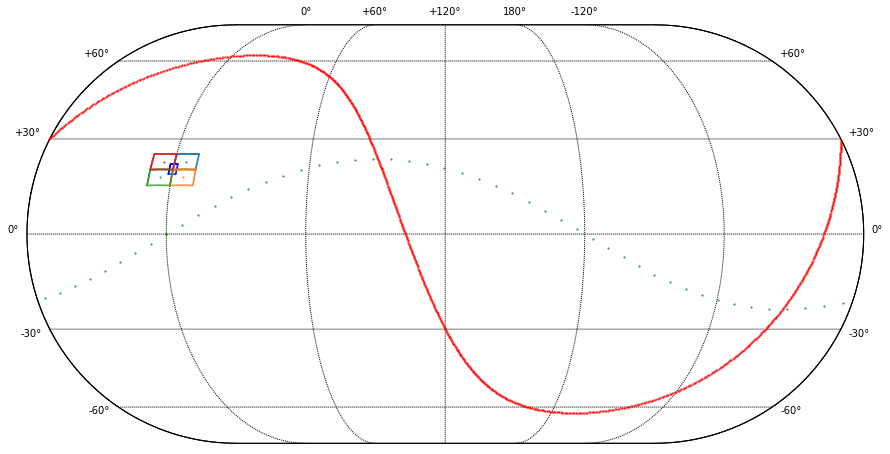

In [15]:
# Show our field on the sky, and highlight overlaping bricks of the sweep files

pl.figure(figsize=(15,10))
color_cycle = pl.rcParams['axes.prop_cycle']

with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)
    m = desiutil.plots.init_sky(ecliptic_color='g')
    dither_poly.draw(m)

    for sweep_poly,c in zip(sweep_polys,color_cycle):
        sweep_poly.draw(m,c=c['color'])

## Create an input target catalog from the sweeps

This uses `desitarget_cuts` to assign target classes to objects. It doesn't assign priorities etc.; that happens when the MTL is made in the next section.

We define a custom SV target bitmasks and patch `desitarget` to implement cuts that use those.

Patch in our own target mask to customize priorities etc.

In [16]:
import apcsv.patch
reload(apcsv.patch)
from apcsv.patch import patch_desitarget_bits

# Restores targetmask to default
reload(desitarget)
reload(desitarget.targetmask)
reload(desitarget.mtl)
reload(desitarget.targets)
reload(desitarget.cuts)

<module 'desitarget.cuts' from '/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/code/desitarget/master/py/desitarget/cuts.py'>

In [17]:
# Check the existing definitions
for _ in mws_mask.names(): print(_)
mws_mask.names() == desitarget.targetmask.mws_mask.names()

MWS_BROAD
MWS_WD
MWS_NEARBY
MWS_BROAD_NORTH
MWS_BROAD_SOUTH
MWS_MAIN_BLUE
MWS_MAIN_BLUE_NORTH
MWS_MAIN_BLUE_SOUTH
MWS_MAIN_RED
MWS_MAIN_RED_NORTH
MWS_MAIN_RED_SOUTH


True

In [18]:
# Patch with our definitions, using the default desitarget targetmask.

# Note that targetmask.yaml is regularly updated in desitarget. The file you point to in this notebook should be that for the
# version of desitarget used by the kernel you're running. In my case I symlink this file to a local clone of desitarget master.

# For SV tests, we will substitute a custom targetmask file.

new_yaml = os.path.join(ROOT_DIR,'targetmasks/targetmask.yaml')
desi_mask, bgs_mask, mws_mask, obsmask, obsconditions = patch_desitarget_bits(desitarget,
                                                                              new_yaml)
# Reload functions
import desitarget.mtl
reload(desitarget.mtl)

import desitarget.targets
reload(desitarget.targets)

import desitarget.cuts
reload(desitarget.cuts);

In [19]:
# Now patch desitarget cuts with our own cuts
# This isn't trivial because target class-specific logic is hardcoded in these fucntions
# To quickly switch between the main survey and an expanded set of target classes, I've written the
# patched functions with a mainsurvey switch. The rest of desitarget doesn't want to see this switch,
# hence the use of partial here.

import apcsv.cuts
reload(apcsv.cuts)

from functools import partial

desitarget.cuts.isMWS_main_colors   = apcsv.cuts.isMWS_main_colors
desitarget.cuts.notinMWS_main_mask  = apcsv.cuts.notinMWS_main_mask

desitarget.cuts.isMWS_faint_colors  = apcsv.cuts.isMWS_faint_colors
desitarget.cuts.notinMWS_faint_mask = apcsv.cuts.notinMWS_faint_mask

desitarget.cuts.isMWS_main          = partial(apcsv.cuts.isMWS_main,mainsurvey=True)

# Patch the target selection functions
desitarget.cuts.set_target_bits     = partial(apcsv.cuts.set_target_bits,mainsurvey=True)

In [20]:
# Check these are what we want -- in this default case, they won't have changed.
for _ in mws_mask.names(): print(_)
mws_mask.names() == desitarget.targetmask.mws_mask.names()

MWS_BROAD
MWS_WD
MWS_NEARBY
MWS_BROAD_NORTH
MWS_BROAD_SOUTH
MWS_MAIN_BLUE
MWS_MAIN_BLUE_NORTH
MWS_MAIN_BLUE_SOUTH
MWS_MAIN_RED
MWS_MAIN_RED_NORTH
MWS_MAIN_RED_SOUTH


True

In [21]:
sweep_filenames = [os.path.basename(_) for _ in original_sweep_files]
sweep_index     = [sweep_filenames.index(os.path.basename(_)) for _ in sweeps_for_sv]

In [26]:
# This cell runs the select_targets function from desitarget.
# This is equivalent to running the select_sv_targets script.

# If true, regenerate targets
# This takes a while, so set this to False if not needed.
reset_target_input = True

with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=UserWarning, module="matplotlib")
    # This tries to set the mpl backend
    from desitarget.QA import _parse_tcnames

from desiutil.log import get_logger
log = get_logger()

print('Have {:d} sweeps as input'.format(len(sweep_index)))

dest = os.path.join(datadir,'sv_targets.fits')

# Which target classes to include
tcnames = _parse_tcnames('MWS,BGS,STD')
# tcnames = _parse_tcnames(tcstring=None, add_all=False)

# Note that we use survey=main here. This isn't exactly how desitarget will work
# in switching between different sets of selection functions.
if (not os.path.exists(dest)) or reset_target_input:
    sweep_input  = [original_sweep_files[_] for _ in sweep_index]
    srcdir       = os.path.dirname(sweep_filenames[0])
    qsoselection = 'colorcuts'
    nside        = io.desitarget_nside()
    survey       = 'main'
    
    # We trap a lot of floating point warnings
    print('Selecting targets...')
    with warnings.catch_warnings(record=True) as w:
        warnings.simplefilter("always")
        targets = desitarget.cuts.select_targets(sweep_input, 
                             numproc = 4,
                             qso_selection = qsoselection, 
                             tcnames = tcnames, 
                             survey  = survey)

        # Report warnings
        _us,_cs = np.unique([_.category for _ in w],return_counts=True)
        print('{} warnings from select_targets'.format(len(w)))
        for _u,_c in zip(_us,_cs):
            print("%15s %10d".format(_u,_c))

    io.write_targets(dest, targets, indir=srcdir, survey=survey,
                     qso_selection=qsoselection, nside=nside)
    print('Wrote targets to {}'.format(dest))
else:
    print('Targets already in {}'.format(dest))

Have 4 sweeps as input
Selecting targets...
INFO:cuts.py:2306:select_targets: Running on the main survey
INFO:cuts.py:782:isMWS_WD: 20346/2256203 NaNs in file...t = 306.0s
INFO:cuts.py:782:isMWS_WD: 18911/2510949 NaNs in file...t = 310.3s
INFO:cuts.py:782:isMWS_WD: 15176/2773763 NaNs in file...t = 315.0s
INFO:cuts.py:782:isMWS_WD: 21400/2735663 NaNs in file...t = 315.4s
0 warnings from select_targets
Wrote targets to /global/u1/a/apcooper/projects/mws_svplan/runs/tutorial_main_survey/run/data/sv_targets.fits


## Prepare MTL

Reads the target list prepared above and converts it to MTL input for fiberassign.

In [27]:
targetdata = fitsio.read(local_targets_path)

In [28]:
# Compute MTL
reset_mtl = True
if not os.path.exists(mtl_path) or reset_mtl:
    
    if reset_mtl:
        if os.path.exists(mtl_path):
            os.remove(mtl_path)
        
    print('computing mtl')
    mtl = desitarget.mtl.make_mtl(targetdata)
    
    # For tests on the main survey selection we need to include BGS,
    # but for SV we only care about MWS (including only overlaps with BGS)
    
    # only include MWS?
    #ismws = mtl['MWS_TARGET']!=0
    #mtl   = mtl[ismws]

    mtl.meta['EXTNAME'] = 'MTL'
    
    mtl.write(mtl_path)
    print('Wrote {}'.format(mtl_path))

    # Print some stats
    print('MWS_TARGETS: {}'.format(np.count_nonzero(mtl['MWS_TARGET']!=0)))
    print('BGS_TARGETS: {}'.format(np.count_nonzero(mtl['BGS_TARGET']!=0)))
    print('DESI_TARGETS: {}'.format(np.count_nonzero(mtl['DESI_TARGET']!=0)))
    print('finished computing mtl')
else:
    mtl = fitsio.read(mtl_path)

computing mtl
INFO:mtl.py:119:make_mtl: 1652 of 449649 targets have priority zero, setting N_obs=0.
Wrote /global/u1/a/apcooper/projects/mws_svplan/runs/tutorial_main_survey/run/data/mtl.fits
MWS_TARGETS: 225970
BGS_TARGETS: 223529
DESI_TARGETS: 449649
finished computing mtl


In [29]:
mws_mask.names()

['MWS_BROAD',
 'MWS_WD',
 'MWS_NEARBY',
 'MWS_BROAD_NORTH',
 'MWS_BROAD_SOUTH',
 'MWS_MAIN_BLUE',
 'MWS_MAIN_BLUE_NORTH',
 'MWS_MAIN_BLUE_SOUTH',
 'MWS_MAIN_RED',
 'MWS_MAIN_RED_NORTH',
 'MWS_MAIN_RED_SOUTH']

## Prepare standard stars

In [30]:
# Standards
reset_standards = True

if not os.path.exists(std_path) or reset_standards:
    std_mask = 0
    for name in ['STD', 'STD_FSTAR', 'STD_WD',
                 'STD_FAINT', 'STD_FAINT_BEST',
                 'STD_BRIGHT', 'STD_BRIGHT_BEST']:
        if name in desi_mask.names():
            std_mask |= desi_mask[name]
            
    is_std  = (targetdata['DESI_TARGET'] & std_mask) != 0
    stddata = targetdata[is_std]

    obscond = np.int_(np.repeat(obsconditions['BRIGHT'], len(stddata)))
    stddata = np.lib.recfunctions.append_fields(stddata, 'OBSCONDITIONS', obscond)  
        
    fitsio.write(std_path, stddata, extname='STD',clobber=True)
    print('{} standards'.format(np.count_nonzero(stddata)))
    print('Wrote standards to {}'.format(std_path))
    print('Finished with standards')
else:
    print('Reading existing standards: {}'.format(std_path))
    stddata = fitsio.read(std_path,extname='STD')

11377 standards
Wrote standards to /global/u1/a/apcooper/projects/mws_svplan/runs/tutorial_main_survey/run/data/std.fits
Finished with standards


## Run fiberassign

In [31]:
# Show fiberassign options
!fiberassign -h

usage: fiberassign [-h] --mtl MTL --sky SKY [--stdstar STDSTAR]
                   [--fibstatusfile FIBSTATUSFILE] [--footprint FOOTPRINT]
                   [--positioners POSITIONERS] [--surveytiles SURVEYTILES]
                   [--outdir OUTDIR] [--starmask STARMASK] [--rundate RUNDATE]
                   [--gfafile GFAFILE] [--nstarpetal NSTARPETAL]
                   [--nskypetal NSKYPETAL] [--overwrite] [--version]

optional arguments:
  -h, --help            show this help message and exit
  --mtl MTL             input targets (FITS file)
  --sky SKY             input sky positions (FITS file)
  --stdstar STDSTAR     input std stars (FITS file)
  --fibstatusfile FIBSTATUSFILE
                        list of positioners and its status (ECSV or txt file)
  --footprint FOOTPRINT
                        list of tiles defining the footprint (FITS file)
  --positioners POSITIONERS
                        list of positioners on the focal plane (FITS file)
  --surveytiles SURVEYTILES


Run fiberassign.

In [52]:
# Set these for main survey or SV
STANDARDS_PER_PETAL  = 10 # SV 20
SKYS_PER_PETAL       = 40 # SV 80

for f in glob.glob(os.path.join(outdir,'*.fits')):
    print('Removing {}'.format(f))
    os.remove(f)

cmd = "fiberassign --mtl {} ".format(mtl_path)
cmd += " --sky {} ".format(sky_path)
cmd += " --stdstar {} ".format(std_path)
# cmd += " --fibstatusfile ./fiberstatus.ecsv"
cmd += " --footprint {}".format(tile_path)
cmd += " --gfafile {}".format(gfa_path)
cmd += " --outdir {} ".format(outdir)
cmd += " --nstarpetal {:d} ".format(STANDARDS_PER_PETAL)
cmd += " --nskypetal {:d}".format(SKYS_PER_PETAL)

print(cmd)
print('starting fiberassign')
ecode = os.system(cmd)
print('finished fiberassign: {}'.format(ecode))

Removing /global/u1/a/apcooper/projects/mws_svplan/runs/tutorial_main_survey/run/output/tile-000000.fits
Removing /global/u1/a/apcooper/projects/mws_svplan/runs/tutorial_main_survey/run/output/fiberassign_000000.fits
fiberassign --mtl /global/u1/a/apcooper/projects/mws_svplan/runs/tutorial_main_survey/run/data/mtl.fits  --sky /project/projectdirs/desi/target/catalogs/dr7.1/0.22.0/skies-dr7.1-0.22.0.fits  --stdstar /global/u1/a/apcooper/projects/mws_svplan/runs/tutorial_main_survey/run/data/std.fits  --footprint /global/u1/a/apcooper/projects/mws_svplan/runs/tutorial_main_survey/tiles/mws_sv_tiles.fits --gfafile /project/projectdirs/desi/target/catalogs/dr7.1/0.22.0/gfas-dr7.1.fits --outdir /global/u1/a/apcooper/projects/mws_svplan/runs/tutorial_main_survey/run/output  --nstarpetal 10  --nskypetal 40
starting fiberassign
finished fiberassign: 0


In [33]:
!ls $outdir

fiberassign_000000.fits  tile-000000.fits


In [34]:
print(outdir)

/global/u1/a/apcooper/projects/mws_svplan/runs/tutorial_main_survey/run/output


We're done with the main work of this notebook. The fiberassign output will be examined in a separate notebook. The following is just extra analysis of the MTL file we made above.

## Basic analysis of the MTL table

In [35]:
mtl[0:2]

RELEASE,BRICKID,BRICKNAME,BRICK_OBJID,MORPHTYPE,RA,DEC,RA_IVAR,DEC_IVAR,DCHISQ [5],EBV,FLUX_G,FLUX_R,FLUX_Z,FLUX_W1,FLUX_W2,FLUX_W3,FLUX_W4,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,FLUX_IVAR_W1,FLUX_IVAR_W2,FLUX_IVAR_W3,FLUX_IVAR_W4,MW_TRANSMISSION_G,MW_TRANSMISSION_R,MW_TRANSMISSION_Z,MW_TRANSMISSION_W1,MW_TRANSMISSION_W2,MW_TRANSMISSION_W3,MW_TRANSMISSION_W4,NOBS_G,NOBS_R,NOBS_Z,FRACFLUX_G,FRACFLUX_R,FRACFLUX_Z,FRACMASKED_G,FRACMASKED_R,FRACMASKED_Z,FRACIN_G,FRACIN_R,FRACIN_Z,ALLMASK_G,ALLMASK_R,ALLMASK_Z,PSFDEPTH_G,PSFDEPTH_R,PSFDEPTH_Z,GALDEPTH_G,GALDEPTH_R,GALDEPTH_Z,FRACDEV,FRACDEV_IVAR,SHAPEDEV_R,SHAPEDEV_R_IVAR,SHAPEDEV_E1,SHAPEDEV_E1_IVAR,SHAPEDEV_E2,SHAPEDEV_E2_IVAR,SHAPEEXP_R,SHAPEEXP_R_IVAR,SHAPEEXP_E1,SHAPEEXP_E1_IVAR,SHAPEEXP_E2,SHAPEEXP_E2_IVAR,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,FIBERTOTFLUX_G,FIBERTOTFLUX_R,FIBERTOTFLUX_Z,REF_ID,GAIA_PHOT_G_MEAN_MAG,GAIA_PHOT_G_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_BP_MEAN_MAG,GAIA_PHOT_BP_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_RP_MEAN_MAG,GAIA_PHOT_RP_MEAN_FLUX_OVER_ERROR,GAIA_ASTROMETRIC_EXCESS_NOISE,GAIA_DUPLICATED_SOURCE,PARALLAX,PARALLAX_IVAR,PMRA,PMRA_IVAR,PMDEC,PMDEC_IVAR,BRIGHTSTARINBLOB,PHOTSYS,TARGETID,DESI_TARGET,BGS_TARGET,MWS_TARGET,PRIORITY_INIT,SUBPRIORITY,NUMOBS_INIT,HPXPIXEL,NUMOBS_MORE,PRIORITY,OBSCONDITIONS
int32,int32,bytes8,int32,bytes4,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,float32,float32,float32,float32,float32,float32,float32,bool,float32,float32,float32,float32,float32,float32,bool,bytes1,int64,int64,int64,int64,int64,float64,int64,int64,int64,int64,int32
7000,462194,0061p235,0,DEV,6.2068956329,23.3774748196,7.49821e+11,9.06937e+11,67655.5 .. 74921.3,0.0524132,5.02015,18.6217,39.1569,49.922,34.4073,78.3791,-132.978,141.387,147.559,13.1137,2.82923,0.526477,0.000985121,2.09554e-05,0.856283,0.900762,0.943216,0.991157,0.99456,0.998837,0.999561,1,3,2,0.00102991,0.000497054,0.00016718,0.00420974,0.00471579,0.00535019,0.999998,0.999998,0.999998,0,0,0,447.59,552.63,38.4359,298.206,349.609,23.296,1.0,1.0,0.780134,20644.4,-0.0668775,9531.52,0.181358,16638.0,0.0,0.0,0.0,0.0,0.0,0.0,2.09841,7.78378,16.3675,2.09841,7.78378,16.3675,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,0.0,0.0,0.0,0.0,0.0,0.0,False,S,30788264159870976,1152921504606846976,131586,0,2100,0.771184098454,1,19901,1,2100,4
7000,462194,0061p235,33,PSF,6.08474618465,23.3767144412,3.22683e+14,4.29448e+14,443572.0 .. 0.0,0.0532155,31.0113,42.2057,45.9274,87.2203,186.842,580.517,551.564,93.7624,165.186,28.0484,3.24372,0.594751,0.00106958,2.2356e-05,0.854252,0.899322,0.942372,0.991022,0.994477,0.998819,0.999554,1,3,2,4.97758e-06,2.33675e-05,2.21234e-05,0.00355007,0.0041595,0.0099193,0.999184,0.999373,0.999255,0,0,0,447.59,561.885,38.1418,298.206,354.017,23.1166,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0762,32.7672,35.6566,24.0762,32.7672,35.6566,2800902208428774272,18.4902,482.874,18.7556,52.2251,18.0558,61.7687,0.230339,False,-0.073709,12.1553,0.117815,7.21073,-0.235001,10.2476,False,S,30788264159871009,3458764513820540928,263172,1792,2000,0.906783787488,1,19901,1,2000,7


WARNING         COUNT
RuntimeWarning  7
  7.301 < r <  21.673
  6.705 < g <  26.330


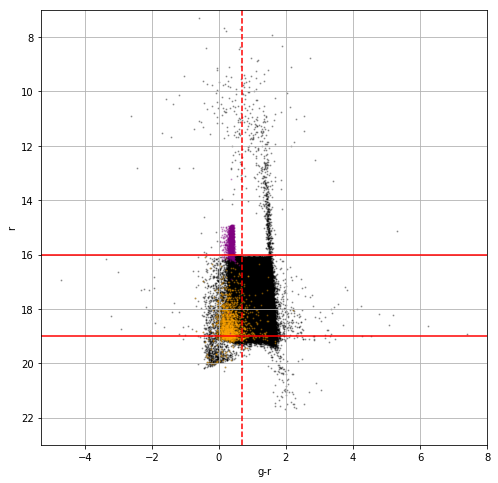

In [45]:
# Colour-magnitude dotplot
f = pl.figure(figsize=(8,8))

with warnings.catch_warnings(record=True) as W:
    #warnings.filterwarnings("ignore",category=RuntimeWarning)
    g = -2.5*np.log10(mtl['FLUX_G'])+22.5
    r = -2.5*np.log10(mtl['FLUX_R'])+22.5
    
    is_mws = mtl['MWS_TARGET'] > 0 
    pl.scatter((g-r)[is_mws],r[is_mws],s=1,alpha=0.3,c='k')
    
    is_bgs_and_mws = (mtl['MWS_TARGET'] > 0) & (mtl['BGS_TARGET'] > 0)
    pl.scatter((g-r)[is_bgs_and_mws],r[is_bgs_and_mws],s=1,alpha=0.3,c='orange')
    
    is_other = (mtl['MWS_TARGET'] == 0) & (mtl['BGS_TARGET'] == 0)
    pl.scatter((g-r)[is_other],r[is_other],s=1,alpha=0.3,c='purple')
    
warning_summary(W)

print("{:7.3f} < r < {:7.3f}".format(r[np.isfinite(r)].min(),r[np.isfinite(r)].max()))
print("{:7.3f} < g < {:7.3f}".format(g[np.isfinite(g)].min(),g[np.isfinite(g)].max()))

pl.xlabel('g-r')
pl.ylabel('r')
pl.axhline(19,c='r')
pl.axhline(16,c='r')
pl.axvline(0.7,c='r',ls='--') # RED/BLUE separation
pl.ylim(23,7)
pl.grid()

0.000   < RA  < 360.000 deg
15.000  < DEC <  25.000 deg
-10.000 < RA (wrapped)  <  10.000 deg


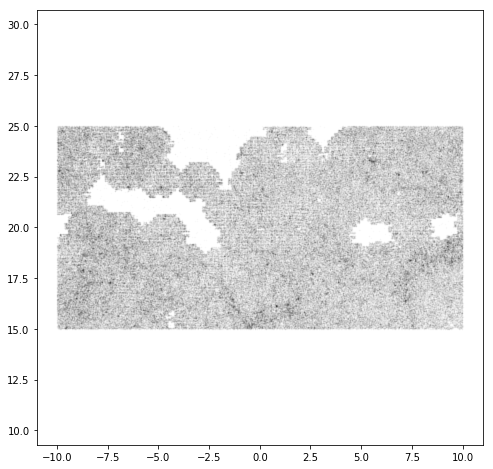

In [46]:
# Sky dotplot
f = pl.figure(figsize=(8,8))

print("{:<7.3f} < RA  < {:7.3f} deg".format(mtl['RA'].min(),mtl['RA'].max()))
print("{:<7.3f} < DEC < {:7.3f} deg".format(mtl['DEC'].min(),mtl['DEC'].max()))

def wrap(angle,offset=-60):
    return np.fmod(angle - offset + 360, 360) + offset

wrapped_ra = wrap(mtl['RA'],-60)
print("{:<7.3f} < RA (wrapped)  < {:7.3f} deg".format(wrapped_ra.min(),wrapped_ra.max()))

pl.scatter(wrapped_ra,mtl['DEC'],c='k',s=1,alpha=0.01)
pl.axis('equal');

In [47]:
# List the different target classes and their obsconditions bitmasks

n  = len(mtl)

print('Total: {} targets in MTL'.format(n))
print()
print("{:20s} {:>10s} {:>10s}".format('Target class','N', 'OBSCOND'))

for mask, xxx_target in [ (desi_mask, 'DESI_TARGET'),
                          (mws_mask,  'MWS_TARGET'),
                          (bgs_mask,  'BGS_TARGET') ]:
    for name in mask.names():
        #- which targets have this bit for this mask set?
        ii = (mtl[xxx_target] & mask[name]) != 0
        #- under what conditions can that bit be observed?
        if np.any(ii):
            # Obsconditions for this class
            _ = obsconditions.mask(mask[name].obsconditions)

            print("{:20s} {:10d} {:10d} {:20s}".format(name, 
                                                ii.sum(),
                                                _,
                                                mask[name].obsconditions))

Total: 449649 targets in MTL

Target class                  N    OBSCOND
STD_FAINT                  9107          3 DARK|GRAY           
STD_WD                      928          7 DARK|GRAY|BRIGHT    
STD_BRIGHT                 6142          4 BRIGHT              
BGS_ANY                  223529          4 BRIGHT              
MWS_ANY                  225970          4 BRIGHT              
MWS_BROAD                110939          7 BRIGHT|GRAY|DARK    
MWS_WD                      928          7 BRIGHT|GRAY|DARK    
MWS_NEARBY                 1337          7 BRIGHT|GRAY|DARK    
MWS_BROAD_NORTH          110939          7 BRIGHT|GRAY|DARK    
MWS_BROAD_SOUTH          110939          7 BRIGHT|GRAY|DARK    
MWS_MAIN_BLUE             83058          7 BRIGHT|GRAY|DARK    
MWS_MAIN_BLUE_NORTH       83058          7 BRIGHT|GRAY|DARK    
MWS_MAIN_BLUE_SOUTH       83058          7 BRIGHT|GRAY|DARK    
MWS_MAIN_RED              30333          7 BRIGHT|GRAY|DARK    
MWS_MAIN_RED_NORTH        30333

In [48]:
# List all the combinations of MWS mask bits and the Tractor types assocated with those bits.
for mwst in np.unique(mtl['MWS_TARGET']):
    w = np.flatnonzero(mtl['MWS_TARGET'] == mwst)
    print(mws_mask.names(mwst))
    print('   ', [_.strip() for _ in (np.unique(mtl['MORPHTYPE'][w]))])

[]
    ['COMP', 'DEV', 'EXP', 'PSF', 'REX']
['MWS_WD']
    ['PSF']
['MWS_NEARBY']
    ['COMP', 'EXP', 'PSF', 'REX']
['MWS_WD', 'MWS_NEARBY']
    ['PSF']
['MWS_BROAD', 'MWS_BROAD_NORTH', 'MWS_BROAD_SOUTH']
    ['PSF']
['MWS_BROAD', 'MWS_WD', 'MWS_BROAD_NORTH', 'MWS_BROAD_SOUTH']
    ['PSF']
['MWS_BROAD', 'MWS_NEARBY', 'MWS_BROAD_NORTH', 'MWS_BROAD_SOUTH']
    ['PSF']
['MWS_MAIN_BLUE', 'MWS_MAIN_BLUE_NORTH', 'MWS_MAIN_BLUE_SOUTH']
    ['PSF']
['MWS_WD', 'MWS_MAIN_BLUE', 'MWS_MAIN_BLUE_NORTH', 'MWS_MAIN_BLUE_SOUTH']
    ['PSF']
['MWS_WD', 'MWS_NEARBY', 'MWS_MAIN_BLUE', 'MWS_MAIN_BLUE_NORTH', 'MWS_MAIN_BLUE_SOUTH']
    ['PSF']
['MWS_MAIN_RED', 'MWS_MAIN_RED_NORTH', 'MWS_MAIN_RED_SOUTH']
    ['PSF']


In [49]:
# List all priority levels
print('{:>10s} {:>10s}'.format('PRIORITY','N'))
for priority,count in zip(*np.unique(mtl['PRIORITY'],return_counts=True)):
    print('{:10d} {:10d}'.format(priority,count))

  PRIORITY          N
         0       1652
      1400     110603
      1500     111721
      1600       1279
      2000      92996
      2100     130470
      2998        928


In [50]:
# Sanity-check ranges of flux and other values

print('{:15s} {:>20s} {:>20s} {:>8s} {:>8s}'.format('PROPERTY','MIN','MAX','NEGATIVE','ZERO'))
for p in ['FLUX_G','FLUX_R','FLUX_IVAR_G','FLUX_IVAR_R','RA','DEC','PRIORITY']:
    print('{:15s} {:20.3f} {:20.3f} {:8d} {:8d}'.format(p,
                                                        mtl[p].min(),
                                                        mtl[p].max(),
                                                        (mtl[p] < 0).sum(),
                                                        (mtl[p] == 0).sum(),
                                                        ))

PROPERTY                         MIN                  MAX NEGATIVE     ZERO
FLUX_G                -421965376.000          2079193.750        9      181
FLUX_R            -2496912949248.000          1201522.500        3      245
FLUX_IVAR_G                    0.000             1896.482        0      181
FLUX_IVAR_R                    0.000              580.747        0      245
RA                             0.000              360.000        0        0
DEC                           15.000               25.000        0        0
PRIORITY                       0.000             2998.000        0     1652


In [51]:
# List the columns in the MTL
mtl.colnames

['RELEASE',
 'BRICKID',
 'BRICKNAME',
 'BRICK_OBJID',
 'MORPHTYPE',
 'RA',
 'DEC',
 'RA_IVAR',
 'DEC_IVAR',
 'DCHISQ',
 'EBV',
 'FLUX_G',
 'FLUX_R',
 'FLUX_Z',
 'FLUX_W1',
 'FLUX_W2',
 'FLUX_W3',
 'FLUX_W4',
 'FLUX_IVAR_G',
 'FLUX_IVAR_R',
 'FLUX_IVAR_Z',
 'FLUX_IVAR_W1',
 'FLUX_IVAR_W2',
 'FLUX_IVAR_W3',
 'FLUX_IVAR_W4',
 'MW_TRANSMISSION_G',
 'MW_TRANSMISSION_R',
 'MW_TRANSMISSION_Z',
 'MW_TRANSMISSION_W1',
 'MW_TRANSMISSION_W2',
 'MW_TRANSMISSION_W3',
 'MW_TRANSMISSION_W4',
 'NOBS_G',
 'NOBS_R',
 'NOBS_Z',
 'FRACFLUX_G',
 'FRACFLUX_R',
 'FRACFLUX_Z',
 'FRACMASKED_G',
 'FRACMASKED_R',
 'FRACMASKED_Z',
 'FRACIN_G',
 'FRACIN_R',
 'FRACIN_Z',
 'ALLMASK_G',
 'ALLMASK_R',
 'ALLMASK_Z',
 'PSFDEPTH_G',
 'PSFDEPTH_R',
 'PSFDEPTH_Z',
 'GALDEPTH_G',
 'GALDEPTH_R',
 'GALDEPTH_Z',
 'FRACDEV',
 'FRACDEV_IVAR',
 'SHAPEDEV_R',
 'SHAPEDEV_R_IVAR',
 'SHAPEDEV_E1',
 'SHAPEDEV_E1_IVAR',
 'SHAPEDEV_E2',
 'SHAPEDEV_E2_IVAR',
 'SHAPEEXP_R',
 'SHAPEEXP_R_IVAR',
 'SHAPEEXP_E1',
 'SHAPEEXP_E1_IVAR',
 'SHAPEE